In [1]:
import cv2
import os
import glob
import numpy as np
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
from skimage.transform import rotate
import matplotlib.pyplot as plt

A simplified data augmentation pipeline, to extend and/or normalize data. Usually in datasets the images have different brightness, so you might want to normalize them. 

In the class there are some functionalities, that work with RGB images and some with flattened, ie. 2D images.

In [2]:
class transform_shapes:
    def __init__(self, data):
        self.data = data
        self.h, self.w = data.shape[1:3]
        self.center_x, self.center_y = int(data.shape[1]/2), int(data.shape[2]/2)

    def affine_trans(self, nr_sampl, nr_per_sample, limit = 10, percent = 0.1):
        """
        Use it with flat image (2D/grayscale, etc.)
        """
        new_samples = []
        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)

        pts1 = np.float32(np.random.uniform(2, self.rows-limit, (nr_per_sample*nr_sampl,3,2)))
        pts2 = []
        for j, i in enumerate(pts1):
            # print(i)
            pts2.append(np.float32([[np.random.uniform(i[0, 0]*(1-percent), i[0, 0]*(1+percent)), np.random.uniform(i[0, 1]*(1-percent), i[0, 1]*(1+percent))],
                                    [np.random.uniform(i[1, 0]*(1-percent), i[1, 0]*(1+percent)), np.random.uniform(i[1, 1]*(1-percent), i[1, 1]*(1+percent))],
                                    [np.random.uniform(i[2, 0]*(1-percent), i[2, 0]*(1+percent)), np.random.uniform(i[2, 1]*(1-percent), i[2, 1]*(1+percent))]]))
        #     print('pts1', i, '\n pts2', pts2[j])
        # print(np.array(pts2).shape, pts1.shape)
        # pts1 = np.float32([[[5, 5], 
        #                    [20, 5],  
        #                    [5, 20]]]* int(nr_per_sample*nr_sampl))
  
        # pts2 = np.float32([[[1, 10], 
        #                    [20, 5],  
        #                    [10, 25]]]* int(nr_per_sample*nr_sampl)) 
        k=0
        for i in range(nr_sampl):
            for j in range(nr_per_sample):
                
                # print(i,j, k)
                M = cv2.getAffineTransform(pts1[k], pts2[k]) 
                new_samples.append(cv2.warpAffine(self.data[i], M, (self.w, self.h), borderValue=(1.,1.,1.)))
                k+=1   
        return new_samples

    def shift(self, nr_sampl, nr_per_sample, shift_x_min = -5, 
              shift_x_max = 5, shift_y_min = -5, shift_y_max = 5):
        """
        Use it with flat image (2D/grayscale, etc.)
        """
        new_samples = []
        shifts_x = np.random.uniform(shift_x_min, shift_x_max, int(nr_per_sample*nr_sampl))
        shifts_y = np.random.uniform(shift_y_min, shift_y_max, int(nr_per_sample*nr_sampl))
        shifts = np.vstack((shifts_x, shifts_y)).T

        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)
        k=0
        M = np.dstack((np.array([[[1, 0], [0, 1]]] * int(nr_per_sample*nr_sampl)), shifts))
        for i in range(nr_sampl):
                for j in range(nr_per_sample):
                    new_samples.append(cv2.warpAffine( self.data[i], M[k], (self.w, self.h), borderValue=(1.,1.,1.)))
                    k+=1  
        return new_samples

    def convolve(self, nr_sampl, kernel = np.array([[0,0.1,0],[0.1,0.6,0.1],[0,0.1,0]])):
        """
        Use it with flat image (2D/grayscale, etc.)
        """
        new_samples = []
        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)

        for i in range(nr_sampl):
            new_samples.append(np.clip(cv2.filter2D(self.data[i],-1,kernel),0,1))

        return new_samples
    
    def rotate(self, nr_sampl, nr_per_sample, max_ang=360, min_ang=-360, rotate=1, mini = 0.25, maxi = 3):
        """
        Use it with flat image (2D/grayscale, etc.)
        """
        scales = np.random.uniform(mini, maxi, (nr_sampl, nr_per_sample)) 
        angles = np.random.uniform(min_ang, max_ang, (nr_sampl, nr_per_sample))
        # angles = np.random.normal(scale = 50, size=(nr_sampl, nr_per_sample))
        new_samples = []
        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)

        if rotate:
            for i in range(nr_sampl):
                for j in range(nr_per_sample):
                    # print(angles[i][j])
                    rot_mat = cv2.getRotationMatrix2D((self.center_x ,self.center_y), angles[i][j], scales[i][j])
                    new_samples.append(cv2.warpAffine( self.data[i], rot_mat, (self.w, self.h), borderValue=(1.,1.,1.)))
        else:
            for i in range(nr_sampl):
                for j in range(nr_per_sample):
                    # print(angles[i][j])
                    rot_mat = cv2.getRotationMatrix2D((self.center_x,self.center_y), 0, scales[i][j])
                    new_samples.append(cv2.warpAffine( self.data[i], rot_mat, (self.w, self.h), borderValue=(1.,1.,1.)))

        
        return new_samples

    def translate_image(self, nr_sampl, nr_per_sample = 1, max_trans = 5):
        """
        Use it with RGB image.
        """
        new_samples = []
        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)
        for i in range(nr_sampl):
            for j in range(nr_per_sample):
                translate_x = max_trans*np.random.uniform() - max_trans/2
                translate_y = max_trans*np.random.uniform() - max_trans/2
                translation_mat = np.float32([[1,0,translate_x],[0,1,translate_y]])
                trans = cv2.warpAffine(self.data[i], translation_mat, (self.w, self.h))
                new_samples.append(trans)
        
        return new_samples

    def rotate_image(self, nr_sampl, nr_per_sample = 1, max_angle =15):
        """
        Use it with RGB image.
        """
        new_samples = []
        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)
        for i in range(nr_sampl):
            for j in range(nr_per_sample):
                rotate_out = rotate(self.data[i], np.random.uniform(-max_angle, max_angle), mode='edge')
                new_samples.append(rotate_out)
        return new_samples

    def projection_transform(self, nr_sampl, nr_per_sample = 1, max_warp=0.8):
        """
        Use it with RGB image.
        """
        #Warp Location
        d = self.h * 0.3 * np.random.uniform(0,max_warp)
       
        new_samples = []
        if nr_sampl > len(self.data):
            nr_sampl = len(self.data)
        for i in range(nr_sampl):
             for j in range(nr_per_sample):
                #Warp co-ordinates
                tl_top = np.random.uniform(-d, d)     # Top left corner, top margin
                tl_left = np.random.uniform(-d, d)    # Top left corner, left margin
                bl_bottom = np.random.uniform(-d, d)  # Bottom left corner, bottom margin
                bl_left = np.random.uniform(-d, d)    # Bottom left corner, left margin
                tr_top = np.random.uniform(-d, d)     # Top right corner, top margin
                tr_right = np.random.uniform(-d, d)   # Top right corner, right margin
                br_bottom = np.random.uniform(-d, d)  # Bottom right corner, bottom margin
                br_right = np.random.uniform(-d, d)   # Bottom right corner, right margin
                    
                ##Apply Projection
                transform = ProjectiveTransform()
                transform.estimate(np.array((
                            (tl_left, tl_top),
                            (bl_left, self.h - bl_bottom),
                            (self.h - br_right, self.h - br_bottom),
                            (self.h - tr_right, tr_top)
                        )), np.array((
                            (0, 0),
                            (0, self.h),
                            (self.h, self.h),
                            (self.h, 0)
                        )))
                output_image = warp(self.data[i], transform, output_shape=(self.h, self.w), order = 1, mode = 'edge')
                new_samples.append(output_image)
        return new_samples

def image_brightness_normalisation(image):
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])
    return image

def preprocess_data_1(X):
    #Remove the mean of data across each channel
    #X = X - np.mean(X_train.mean(axis=(1,2)), axis=0)
    X = X - np.mean(X, axis=0)
    
    X /= np.std(X, axis=0)
    return X
    
def preprocess_data_2(X):

    for i in range(len(X)):
        X[i,:,:,:] = image_brightness_normalisation(X[i,:,:,:])
    X = X/255.0 - 0.5
    return X

def transform_image(image, nr_per_sample = 1, max_angle = 15, max_trans = 5,max_warp = 0.8, b_min = 0.35, b_max = 5.):
    ## Simple pipline to take an input image and apply a serise of simple
    ## Distortions to augment the training data set
    ## (note: this function will rescale pixel values between 0-1)
    ##
    height, width, channels = image.shape
    #Rotate Image
    rotated_image = transform_shapes(np.array([image])).rotate_image(1, nr_per_sample = nr_per_sample, max_angle = max_angle)
    #Translate Image
    translated_image = transform_shapes(np.array(rotated_image)).translate_image(len(rotated_image), nr_per_sample = nr_per_sample, max_trans = max_trans)
    #Project Image
    output_image = transform_shapes(np.array(translated_image)).projection_transform(len(translated_image), nr_per_sample = nr_per_sample, max_warp = max_warp)
    # for i  in range(len(output_image)):
        # pass
        # output_image[i] =
        # rnd = np.random.uniform(-output_image[i].mean()*bright_perc, output_image[i].mean()*bright_perc)
        # output_image[i] += rnd
        # output_image[i] = (output_image[i]/np.max(output_image[i])*255.0).astype(np.uint8)

    return [(np.clip(img*np.random.uniform(b_min, b_max),0,1)*255.).astype(np.uint8) for img in output_image]


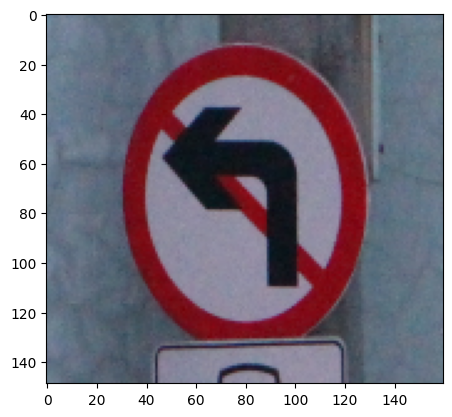

In [3]:
img_path = r'./database/train/A/A_0001.png'
img = cv2.imread(img_path)
plt.imshow(img[:,:,::-1])
plt.show()

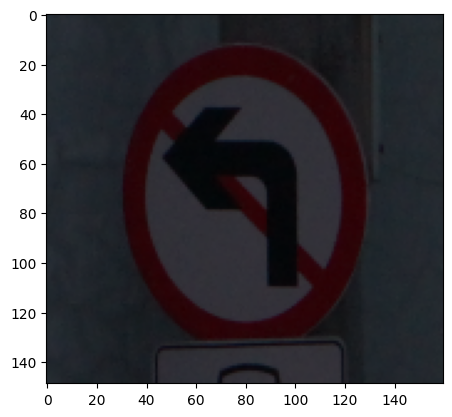

In [4]:
img_path = r'./database/train/A/A_0001.png'
img = cv2.imread(img_path)
bright_perc = 0.35
plt.imshow(np.clip(img*bright_perc,0,255).astype(np.uint8)[:,:,::-1])
plt.show()

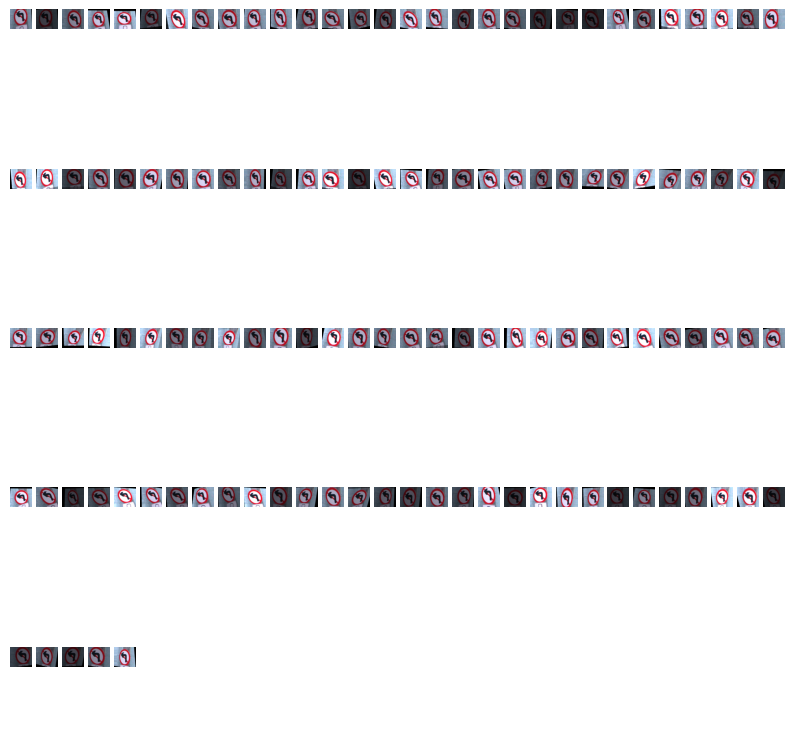

In [229]:
arr = transform_image(img, nr_per_sample=5, b_max=2.)

M = 30
N = len(arr)//M + 1


fig, axs = plt.subplots(N, M, figsize=(10, 10))

for i in range(N):
    for j in range(M):
        if i*M + j < len(arr):
            axs[i, j].imshow(arr[i * M + j][:,:,::-1])
            axs[i, j].axis('off')  # Turn off axis labels for cleaner display
        else:
            axs[i, j].axis('off')  # Turn off axis labels for empty subplots


plt.show()


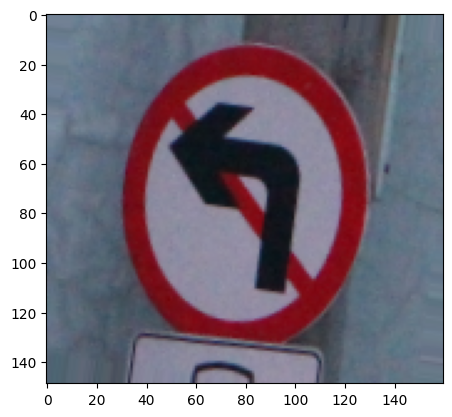

In [4]:
plt.imshow(transform_shapes(np.array([img])).rotate_image(1)[0][:,:,::-1])

In [5]:
tuple((5, *img.shape[:2]))

(5, 149, 160)

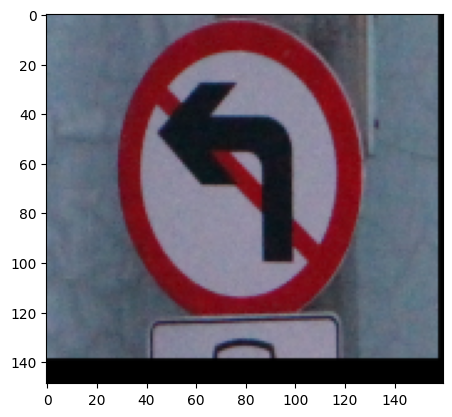

In [6]:
plt.imshow(transform_shapes(np.array([img])).translate_image(1,25)[0][:,:,::-1])

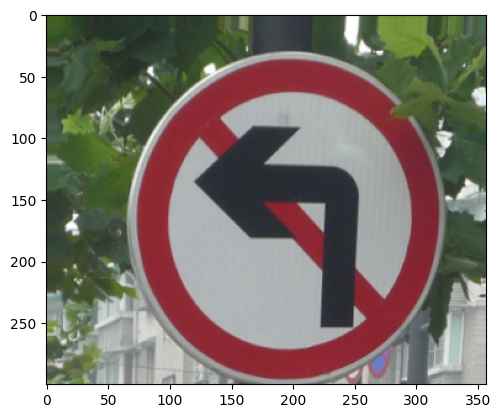

In [43]:
plt.imshow(transform_shapes(np.array([img])).projection_transform(1, nr_per_sample=3,max_warp=0.8)[2][:,:,::-1])

In [49]:
transform_shapes(np.array([img])).projection_transform(1, nr_per_sample=3,max_warp=0.8)[2].shape

(300, 357, 3)

In [55]:
im = Image.fromarray((transform_shapes(np.array([img])).projection_transform(1, nr_per_sample=3,max_warp=0.8)[2]*255).astype('uint8')[:,:,::-1], "RGB") 
im.save("your_file.jpeg")

In [53]:
transform_shapes(np.array([img])).projection_transform(1, nr_per_sample=3,max_warp=0.8)[2]

array([[[0.13207728, 0.32933506, 0.20125605],
        [0.15196574, 0.32558067, 0.20543987],
        [0.17502627, 0.31589421, 0.21145617],
        ...,
        [0.22064345, 0.32728497, 0.25100113],
        [0.23233558, 0.33731082, 0.26013795],
        [0.23572294, 0.3399915 , 0.26258144]],

       [[0.13206406, 0.32935489, 0.20126927],
        [0.15189325, 0.3255609 , 0.20539374],
        [0.17505255, 0.31597961, 0.21151529],
        ...,
        [0.23528504, 0.35767559, 0.27620476],
        [0.24330643, 0.36722244, 0.2848695 ],
        [0.24589056, 0.36745918, 0.28510624]],

       [[0.13205084, 0.32937472, 0.20128249],
        [0.15182076, 0.32554113, 0.20534761],
        [0.17507883, 0.31606501, 0.21157442],
        ...,
        [0.24985989, 0.35686519, 0.26969875],
        [0.24850244, 0.3583283 , 0.27360524],
        [0.24576755, 0.35691051, 0.27195115]],

       ...,

       [[0.22030759, 0.43875115, 0.36577069],
        [0.22887635, 0.44627894, 0.37397439],
        [0.22463571, 0

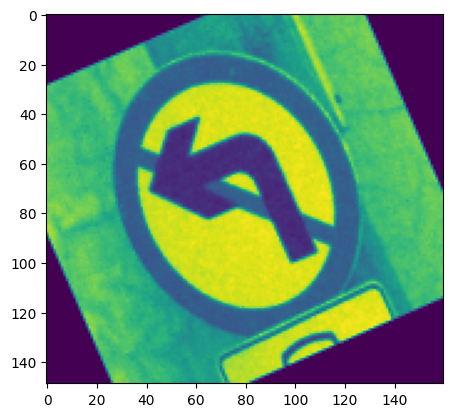

In [8]:
plt.imshow(transform_shapes(np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)])).rotate(nr_sampl=1,nr_per_sample=1,
            max_ang=25,min_ang=-25,maxi=1, mini = .8)[0])

In [6]:
def count_files(directory):
    file_nrs = []
    for root, dirs, files in os.walk(directory):
        file_count = len(files)
        file_nrs.append(file_count)
        print(f'Total number of files in {root}: {file_count}')
    return file_nrs

def load_image_paths(folder_path, image_extensions=['jpg', 'jpeg', 'png', 'gif']):
    image_paths = []
    
    # Create a list of allowed image file extensions
    allowed_extensions = ['*.' + ext for ext in image_extensions]

    # Use glob to find files matching the allowed extensions
    for extension in allowed_extensions:
        pattern = os.path.join(folder_path, '**', extension)
        image_paths.extend(glob.glob(pattern, recursive=True))

    return image_paths

In [15]:
img = cv2.imread('./database2/train/B/B_1364.png')
im = cv2.resize(img, (25,25))

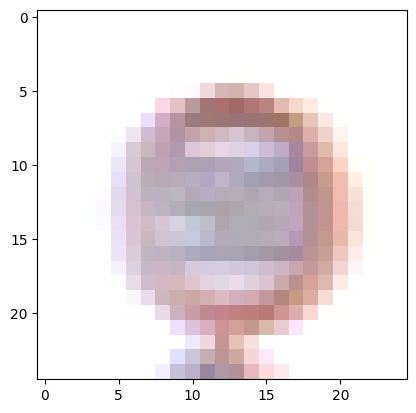

In [16]:
plt.imshow(im[:,:,::-1])

In [7]:
from PIL import Image
import os

def get_image_resolution(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return np.array([width, height])

def find_smallest_resolution_image(folder_path, image_extensions=['jpg', 'jpeg', 'png', 'gif']):
    smallest_resolution_val = float('inf')
    smallest_resolution_image = None

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(tuple(image_extensions)):
                image_path = os.path.join(root, file)
                resolution = get_image_resolution(image_path)

                if np.prod(resolution) < smallest_resolution_val:
                    smallest_resolution = resolution
                    smallest_resolution_val = np.prod(resolution)
                    smallest_resolution_image = image_path

    return smallest_resolution_image, smallest_resolution

# Example usage:
folder_path = './database2/'
smallest_image, resolution = find_smallest_resolution_image(folder_path)

if smallest_image:
    print(f"Smallest resolution image: {smallest_image}")
    print(f"Resolution: {resolution} pixels")
else:
    print("No images found.")


Smallest resolution image: ./database2/train/B/B_1364.png
Resolution: [25 25] pixels


In [8]:
directory_path = './database2/train/'
file_nrs = np.array(count_files(directory_path))
# file_nrs = np.sort(file_nrs)
diffs = - file_nrs + max(file_nrs)
n = 3
needed = np.ceil(diffs[1:]/(n**3))
needed, file_nrs[1:], diffs[1:]

Total number of files in ./database2/train/: 0
Total number of files in ./database2/train/A: 276
Total number of files in ./database2/train/B: 3108
Total number of files in ./database2/train/C: 632
Total number of files in ./database2/train/D: 1272
Total number of files in ./database2/train/E: 324
Total number of files in ./database2/train/F: 4172


(array([145.,  40., 132., 108., 143.,   0.]),
 array([ 276, 3108,  632, 1272,  324, 4172]),
 array([3896, 1064, 3540, 2900, 3848,    0]))

In [9]:
def aug_imgs(idx, folder_path = './database2/test/A/',
             aug_dir = "./database2/train_aug/aug_A/",
             aug_name = 'aug_A',
             nr_per_sample = 3, b_min = .35, b_max = 3., max_angle = 10, 
             max_trans = 5, max_warp = .7):
    image_paths = load_image_paths(folder_path)
    name_idx = 0

    for id in idx:
        tr_imgs = transform_image(cv2.imread(image_paths[id]), nr_per_sample = nr_per_sample,
                                  b_min = b_min, b_max = b_max, max_angle = max_angle,
                                  max_warp = max_warp, max_trans = max_trans)
        for im in tr_imgs:
            temp = Image.fromarray(im[:,:,::-1], "RGB") 
            temp.save(f"{aug_dir}{aug_name}_{name_idx:04d}.jpg")
            name_idx += 1

In [289]:
n = 1
lett = 'A'
idx = np.random.choice(np.arange(file_nrs[n]), needed[n-1].astype(int), replace = 0)
aug_imgs(idx, 
         folder_path =  f'./database2/train/{lett}/',
             aug_dir = f"./database2/train_aug/aug_{lett}/",
             aug_name = f'aug_{lett}', b_min=.75, b_max=2.)

In [253]:
idx = np.random.choice(np.arange(file_nrs[1]), needed[0].astype(int), replace = 0)
idx, idx.shape, np.unique(idx).shape

(array([161, 202,  19, 259, 141, 166,  13,  11,  22,  88, 144,  35, 251,
        233,  36,  54, 180, 261, 194, 119,   8,  53,  41,  51, 264, 217,
         15, 158, 135, 201, 107, 223, 195,  68,  50, 268, 140,   7, 229,
        237, 235, 266,  57, 193,  20, 150,  64,  40,  24,  71,  97, 263,
        248,  34, 227, 215,  39,  48, 212, 244, 236, 162,  63, 186, 255,
        192, 143, 170,  33, 245, 262,  75,  90, 142, 176, 122,  72, 109,
        209, 218,   0, 117, 214,  94,  46, 199, 151, 221,  67,  47,   9,
         70,  77, 113, 136, 271,  80,  49, 254, 116, 183, 108, 247, 184,
        256, 249, 216,  79, 102, 239, 126,  43, 208,  10,  27,  76, 181,
        138, 211, 139, 154, 204, 230, 164, 123, 131, 269, 260,  31, 160,
        196,   6, 190, 104, 129, 124, 175,  93, 220, 155,  61, 172,  84,
         12, 200]),
 (145,),
 (145,))

In [267]:
folder_path = './database2/test/A/'
image_paths = load_image_paths(folder_path)

In [263]:
arr_temp = transform_image(cv2.imread(image_paths[idx[0]]), nr_per_sample = n, b_max = 3.)

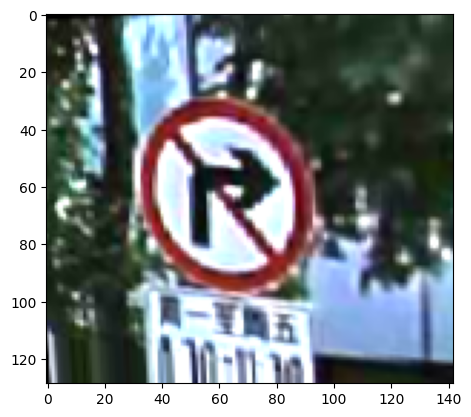

In [265]:
plt.imshow(arr_temp[20][:,:,::-1])

In [10]:
def resize_images(source_folder, destination_folder, target_size=(300, 200)):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get a list of all files in the source folder
    files = os.listdir(source_folder)

    # Filter only image files (you can customize the extensions if needed)
    image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

    # Resize and save each image
    for image_file in image_files:
        source_path = os.path.join(source_folder, image_file)
        destination_path = os.path.join(destination_folder, image_file)

        # Open the image
        image = Image.open(source_path)

        # Resize the image
        resized_image = image.resize(target_size)

        # Save the resized image
        resized_image.save(destination_path)
        print(f"Resized and saved: {image_file} -> {os.path.basename(destination_path)}")

In [12]:
res_source = './database2/train/A/'
res_dest = './database2/resized/train/A/'
size = (125,125)
resize_images(res_source, res_dest, target_size=size)

Resized and saved: A_0018.png -> A_0018.png
Resized and saved: A_0019.png -> A_0019.png
Resized and saved: A_0020.png -> A_0020.png
Resized and saved: A_0021.png -> A_0021.png
Resized and saved: A_0022.png -> A_0022.png
Resized and saved: A_0023.png -> A_0023.png
Resized and saved: A_0024.png -> A_0024.png
Resized and saved: A_0025.png -> A_0025.png
Resized and saved: A_0026.png -> A_0026.png
Resized and saved: A_0027.png -> A_0027.png
Resized and saved: A_0028.png -> A_0028.png
Resized and saved: A_0029.png -> A_0029.png
Resized and saved: A_0030.png -> A_0030.png
Resized and saved: A_0031.png -> A_0031.png
Resized and saved: A_0032.png -> A_0032.png
Resized and saved: A_0033.png -> A_0033.png
Resized and saved: A_0034.png -> A_0034.png
Resized and saved: A_0035.png -> A_0035.png
Resized and saved: A_0036.png -> A_0036.png
Resized and saved: A_0038.png -> A_0038.png
Resized and saved: A_0039.png -> A_0039.png
Resized and saved: A_0040.png -> A_0040.png
Resized and saved: A_0041.png ->